In [1]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells, extend_spells, gb_index, make_daily
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import DataHandler, open_da, data_path, compute_anomalies_pl, coarsen_da, compute_anomalies_ds
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    PRETTIER_VARNAME,
    YEARS,
    KAPPA,
    compute,
    get_region,
    infer_direction,
    polars_to_xarray,
    xarray_to_polars,
    labels_to_mask,
    extract_season_from_df,
    DUNCANS_REGIONS_NAMES,
    UNITS,
    N_WORKERS,
    do_rle,
    do_rle_fill_hole,
)
from jetutils.jet_finding import JetFindingExperiment, jet_integral_haversine, find_all_jets, haversine_from_dl, jet_position_as_da, add_normals, gather_normal_da_jets, average_jet_categories, connected_from_cross, get_double_jet_index, iterate_over_year_maybe_member, track_jets, average_jet_categories_v2, spells_from_cross, spells_from_cross_catd
from jetutils.plots import COLORS, COLORS_EXT, PINKPURPLE, Clusterplot, gather_normal_da_jets_wrapper, _gather_normal_da_jets_wrapper, make_transparent, honeycomb_panel, plot_seasonal, interp_jets_to_zero_one
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from tqdm import tqdm
import polars.selectors as cs


%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  225280


In [2]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    labels = labels.cast({"time": pl.Datetime("ms")})
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)

In [3]:
dh = DataHandler.from_specs("ERA5", "plev", "high_wind", "6H", "all", None, -80, 40, 15, 80)
exp = JetFindingExperiment(dh)
all_jets_one_df = exp.find_jets(force=False, alignment_thresh=0.6, base_s_thresh=0.55, int_thresh_factor=0.35, hole_size=10)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=5, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})

props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})
props_as_df = average_jet_categories(props_uncat, polar_cutoff=0.5)

summer_filter = summer.rename("time").to_frame()
props_summer = summer_filter.join(props_as_df, on="time")
ds = exp.ds

phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 5e8))

phat_jets = all_jets_one_df.filter(phat_filter)
phat_jets_catd = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar") > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)

In [4]:
diffs = (
    phat_props_catd[["jet", "time", "mean_lon", "mean_lat"]]
    .group_by("jet")
    .agg(
        pl.col("time"),
        cs.numeric().diff().abs(),
        (
            pl.col("time").diff().cast(pl.Float32())
            / pl.duration(
                seconds=1, time_unit=props_as_df["time"].dtype.time_unit
            ).cast(pl.Float32())
        ).alias("dt"),
        pl.col("mean_lat").alias("actual_lat"),
    )
    .explode(cs.all().exclude("jet"))
    .sort("time", "jet", descending=[False, True])
    .with_columns(
        com_speed=(
            haversine_from_dl(pl.col("actual_lat"), pl.col("mean_lon"), pl.col("mean_lat"))
            / pl.col("dt")
        )
        .cast(pl.Float32())
    )
    .rolling("time", period="2d", offset="-1d", group_by="jet")
    .agg(pl.col("com_speed").mean())
)
phat_props_catd = phat_props_catd.join(diffs[["time", "jet", "com_speed"]], on=["time", "jet"])
phat_props_catd_summer = summer_filter.join(phat_props_catd, on="time")

In [5]:
# cross_phat = track_jets(phat_jets, n_next=3)
# cross_phat.write_parquet(exp.path.joinpath("cross_phat.parquet"))
# cross_catd = track_jets(phat_jets_catd, n_next=3)
# cross_catd.write_parquet(exp.path.joinpath("cross_catd.parquet"))

cross_phat = pl.read_parquet(exp.path.joinpath("cross_phat.parquet"))
cross_catd = pl.read_parquet(exp.path.joinpath("cross_catd.parquet"))

spells_list_catd = spells_from_cross_catd(cross_catd, season=summer, q_STJ=0.96, q_EDJ=0.9)
spells_list = spells_from_cross(phat_jets, cross_phat, dis_polar_thresh=0.15, dist_thresh=1.3e5, season=summer, q_STJ=0.99, q_EDJ=0.95)

spells_from_jet_daily_stj_cs = get_persistent_jet_spells(
    phat_props_catd_summer,
    "com_speed",
    jet="STJ",
    q=0.8,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=24),
).with_columns(spell_of=pl.lit("STJ"))
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(
    phat_props_catd_summer,
    "com_speed",
    jet="EDJ",
    q=0.8,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=24),
).with_columns(spell_of=pl.lit("EDJ"))
spells_list = spells_list | {
    "STJ_com": spells_from_jet_daily_stj_cs.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}),
    "EDJ_com": spells_from_jet_daily_edj_cs.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}),
}
spells_list = spells_list | {f"{key}_catd": val for key, val in spells_list_catd.items()}

for name, spell in spells_list.items():
    print(name, spell["spell"].n_unique())
    

kwargs = dict(time_before=datetime.timedelta(hours=24), time_after=datetime.timedelta(hours=24))
daily_spells_list = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_list.items()}

STJ 29
EDJ 45
STJ_com 25
EDJ_com 16
STJ_catd 37
EDJ_catd 30


## Spells when?

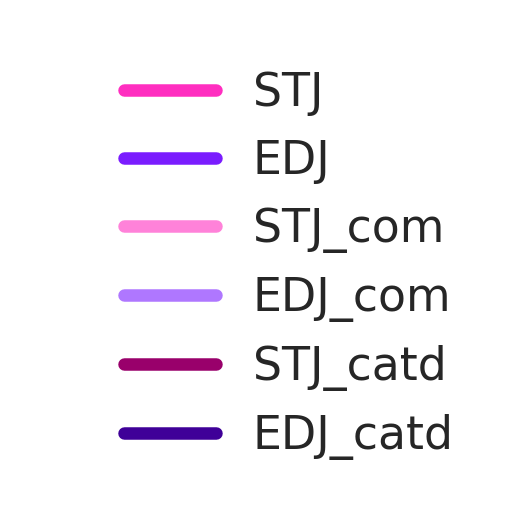

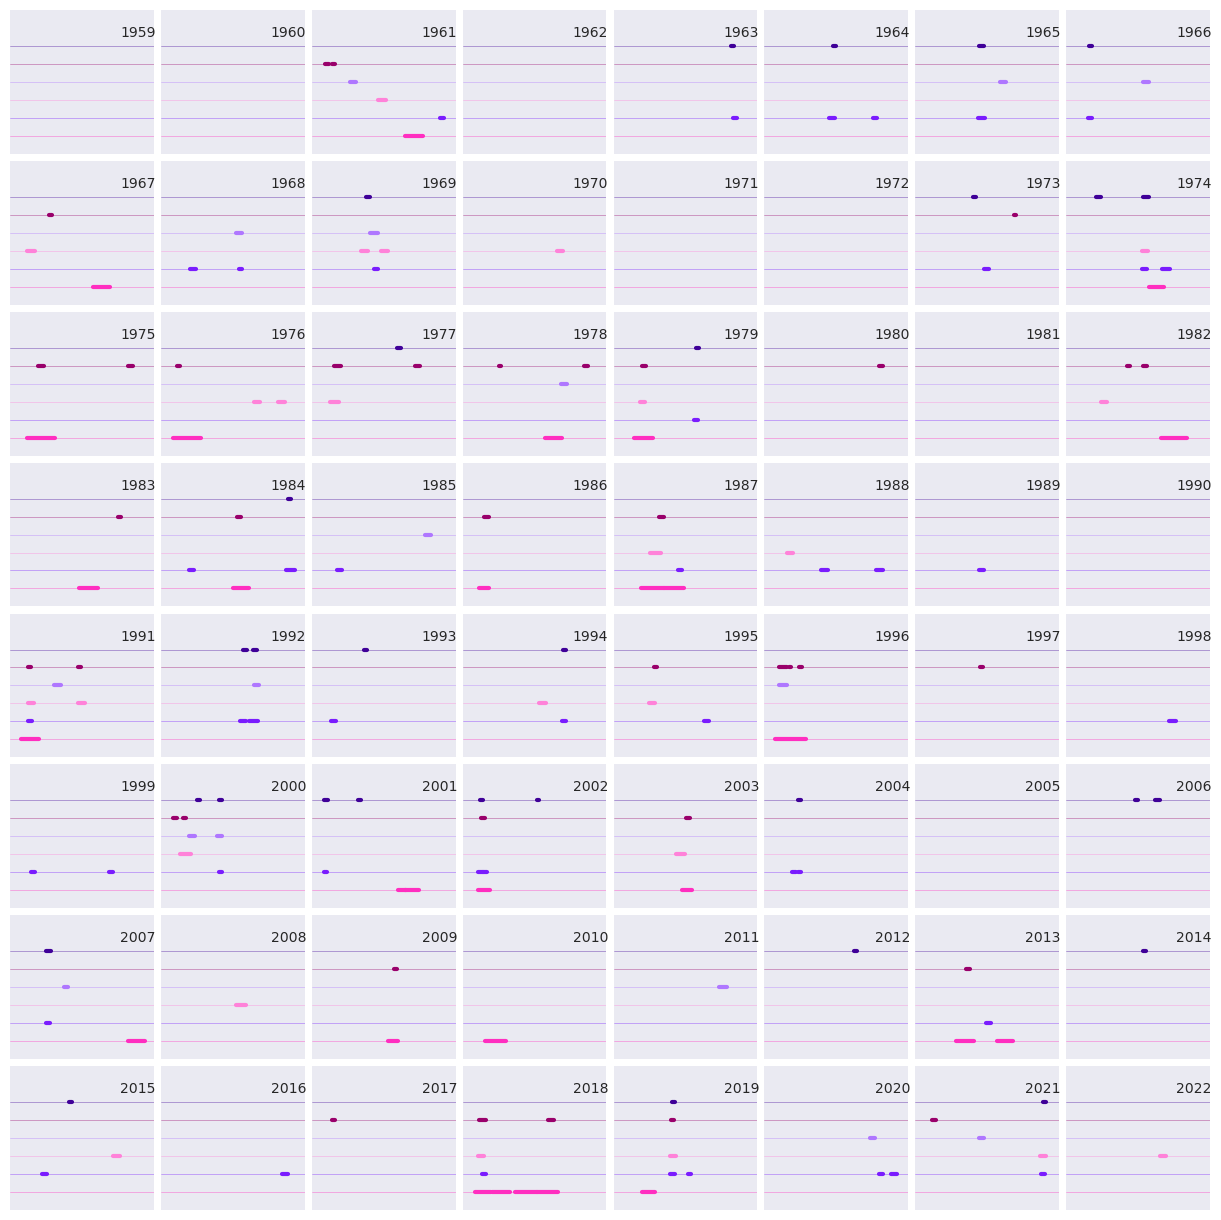

In [6]:
plt.style.use('seaborn-v0_8-darkgrid')
colors = [COLORS[2], COLORS[1], COLORS_EXT[6], COLORS_EXT[3], COLORS_EXT[8], COLORS_EXT[5]]

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.axis("off")
for spell_name, color in zip(spells_list, colors):
    ax.plot([], [], color=color, lw=3, label=spell_name)
ax.legend()
plt.show()
min_summer, max_summer =  summer.dt.ordinal_day().unique().first(),  summer.dt.ordinal_day().unique().last()
fig, axes = plt.subplots(
    8,
    8,
    figsize=(12, 12),
    gridspec_kw=dict(wspace=.05, hspace=.05, left=0, right=1, bottom=0, top=1),
    subplot_kw=dict(xticks=[], yticks=[], xlim=[-1, max_summer - min_summer], ylim=[-1, len(colors) + 1]),
)
axes = axes.ravel()
for ax, year in zip(axes, YEARS):
    ax.text(110, len(spells_list) - 0.5, f"{year}", fontsize=10)
    for j, (name_, spell) in enumerate(spells_list.items()):
        ax.plot([-1, max_summer - min_summer], [j, j], color=colors[j], lw=0.5, ls="solid", alpha=0.5)
        spell_ = spell.filter(pl.col("time").dt.year() == year)
        if len(spell_) == 0:
            continue
        for s, indiv_spell in spell_.group_by("spell"):
            x = [
                indiv_spell["time"].dt.ordinal_day().first() - min_summer,
                indiv_spell["time"].dt.ordinal_day().last() - min_summer,
            ]
            y = [j, j]
            ax.plot(x, y, color=colors[j], lw=3)
plt.show()
plt.style.use('default')

## Props

In [37]:
plt.style.use("default")
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("font", size=14)
plt.rc("text", usetex=False)
plt.rc("savefig", dpi=300)
plt.rc("savefig", bbox="tight")

data_vars = [
    "mean_lon",
    "mean_lat",
    "s_star",
    "width",
    "tilt",
    "waviness1",
    "waviness2",
    "int",
    "is_polar",
]
for spell_of in ["STJ" ,"EDJ", "STJ_catd" ,"EDJ_catd", "STJ_com" ,"EDJ_com"]:
    spells_from_jet = spells_list[spell_of]
    props_masked = mask_from_spells_pl(
        spells_from_jet, phat_props_catd_summer, time_before=datetime.timedelta(days=4)
    )
    aggs = {col: pl.col(col).mean() for col in data_vars}
    aggs = aggs | {f"{col}_10": pl.col(col).quantile(0.33) for col in data_vars}
    aggs = aggs | {f"{col}_90": pl.col(col).quantile(0.66) for col in data_vars}
    aggs = aggs | {"alive": pl.col("time").len()}
    mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
    aggs_ = {col: pl.col(col).quantile(0.25) for col in data_vars}
    q25 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_)
    aggs_ = {col: pl.col(col).quantile(0.75) for col in data_vars}
    q75 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs_)
    fig, axes = plt.subplots(3, 3, figsize=(11, 11), tight_layout=False)
    axes = axes.ravel()
    means = phat_props_catd_summer.group_by("jet", maintain_order=True).agg(**aggs)
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("jet") == jet)
        q25_ = q25.filter(pl.col("jet") == jet)
        q75_ = q75.filter(pl.col("jet") == jet)
        x = to_plot["relative_index"].unique().to_numpy()
        for ax, data_var in zip(axes, data_vars):
            factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
            factor = 1e5 if data_var == "width" else factor
            ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
            ax.fill_between(x, q25_[data_var] / factor, q75_[data_var] / factor, color=COLORS[2 - j], alpha=0.4)
            mean = means.filter(pl.col("jet")==jet)[data_var].item() / factor
            q10 = means.filter(pl.col("jet")==jet)[f"{data_var}_10"].item() / factor
            q90 = means.filter(pl.col("jet")==jet)[f"{data_var}_90"].item() / factor
            ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
            ax.plot([x[0], x[-1]], [q10, q10], color=COLORS[2 - j], ls="dotted", lw=.5)
            ax.plot([x[0], x[-1]], [q90, q90], color=COLORS[2 - j], ls="dotted", lw=.5)
            if j == 0:
                factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
                ax.set_title(
                    rf"{PRETTIER_VARNAME.get(data_var, data_var)} [{factor_str}{UNITS.get(data_var, '')}]"
                )
            ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
    for i, ax in enumerate(axes):
        ax.axvline(0, zorder=1, color="black", lw=2)
        ax.set_xlabel("Relative time around onset [days]", color="black")
    fig.set_tight_layout(True)
    fig.suptitle(f"{spell_of}, {props_masked['spell'].n_unique()} spells")
    fig.savefig(f"{FIGURES}/jet_persistence/{spell_of}_props.png")
    plt.close()

100%|██████████| 12/12 [00:28<00:00,  2.39s/it]


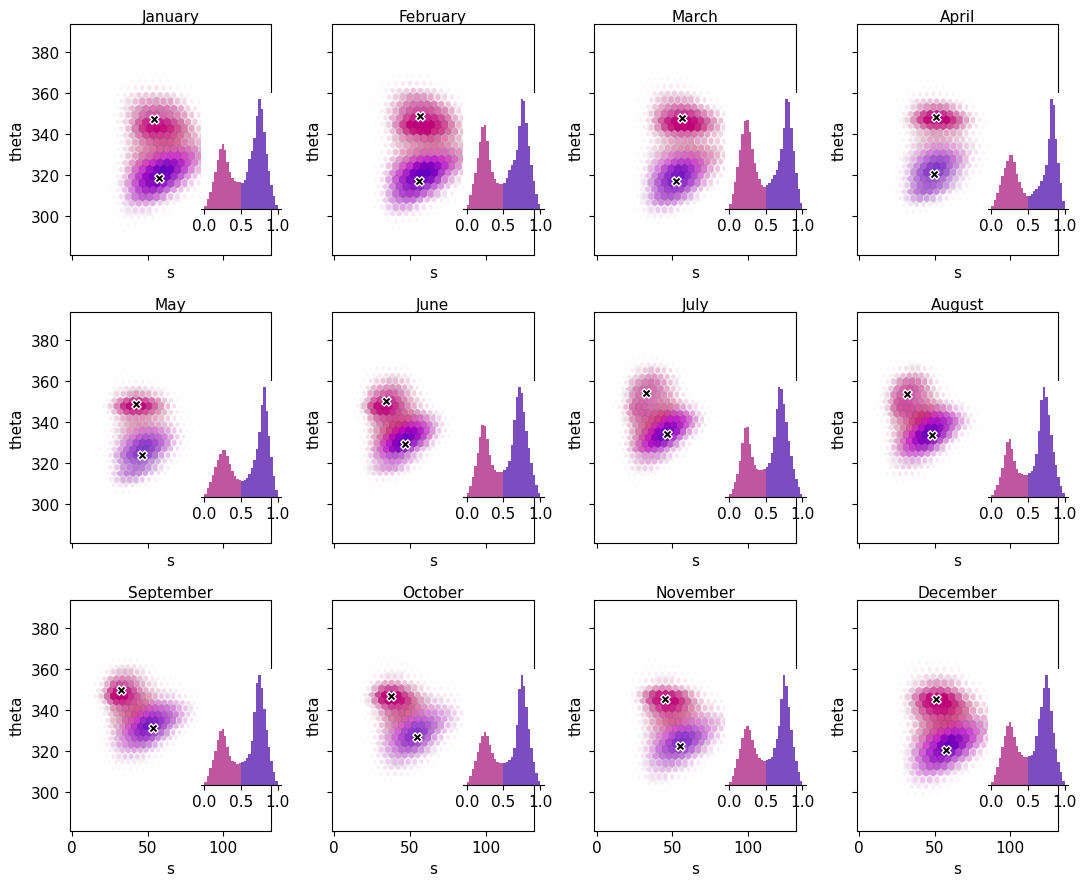

In [4]:
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
from tqdm import trange
from jetutils.jet_finding import extract_features
from jetutils.definitions import MONTH_NAMES

xys = []
all_jets = all_jets_one_df

xys = np.array(xys)
fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()
pair = ["s", "theta", "is_polar"]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
bins = np.linspace(0, 1, 31)
for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    probas = X[pair[2]]
    center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
    center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
    X1D = X["is_polar"]
    
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
    
    plt.draw()
        
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
        
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    ax.set_title(MONTH_NAMES[month - 1])
    ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T, facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
    iax = ax.inset_axes([0.65, 0.2, 0.4, 0.5])
    X1D = np.clip(X1D, 0, 1)
    iax.hist(X1D, bins=bins, alpha=0.5, color="black")
    iax.hist(X1D[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
    iax.hist(X1D[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
    iax.set_xticks([0, 0.5, 1])
    iax.set_yticks([])
    iax.spines[["left", "right", "top"]].set_visible(False)
    plt.draw()
# fig.savefig(f"{FIGURES}/jet_detection_demo/gmix_demo")

# Jet relative stuff

In [6]:
args = ["all", None, *get_region(ds), "all"]
da_T = open_da(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args,
)
da_T = compute(da_T.sel(time=summer_daily), progress_flag=True)
da_T_upper = open_da(
    "ERA5",
    "plev",
    "t300",
    "dailymean",
    *args,
)
da_T_upper = compute(da_T_upper.sel(time=summer_daily), progress_flag=True)
da_tp = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args,
)
da_tp = compute(da_tp.sel(time=summer_daily), progress_flag=True)
da_apvs = open_da(
    "ERA5",
    "thetalev",
    "apvs",
    "dailyany",
    *args,
)
da_apvs = compute(da_apvs.sel(time=summer_daily), progress_flag=True)
da_cpvs = open_da(
    "ERA5",
    "thetalev",
    "cpvs",
    "dailyany",
    *args,
)
da_cpvs = compute(da_cpvs.sel(time=summer_daily), progress_flag=True)
da_pv = open_da(
    "ERA5",
    "thetalev",
    "PV",
    "dailymean",
    *args,
)
da_pv = compute(da_pv.sel(time=summer_daily), progress_flag=True)

[########################################] | 100% Completed | 12.59 s
[########################################] | 100% Completed | 17.01 s
[########################################] | 100% Completed | 12.78 s
[########################################] | 100% Completed | 3.32 sms
[########################################] | 100% Completed | 3.22 sms
[########################################] | 100% Completed | 40.34 s


In [7]:
def symmetrize_p(
    pvals: xr.DataArray | np.ndarray, direction: int, q: float
) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q

100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


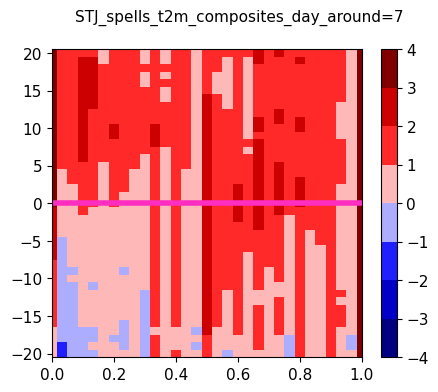

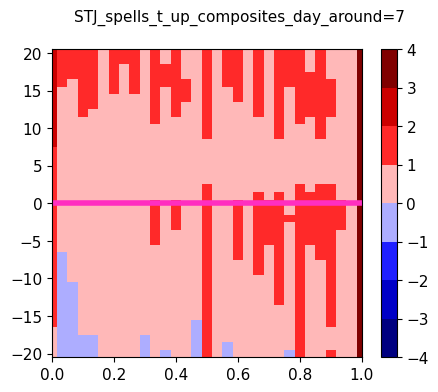

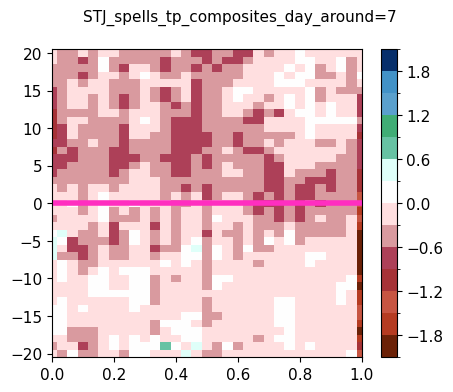

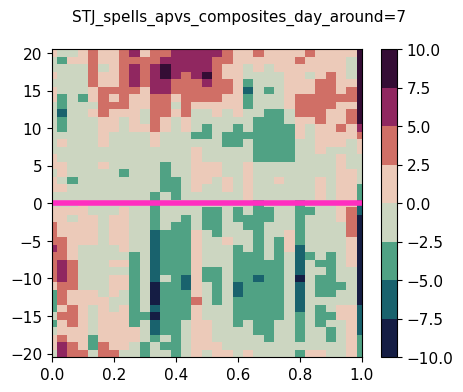

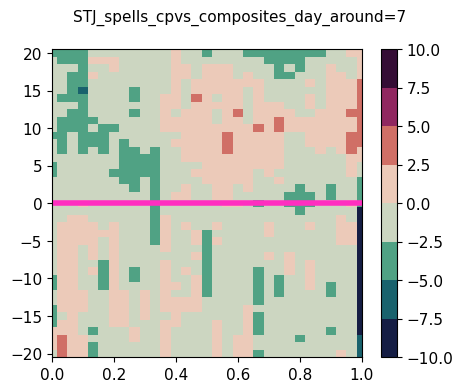

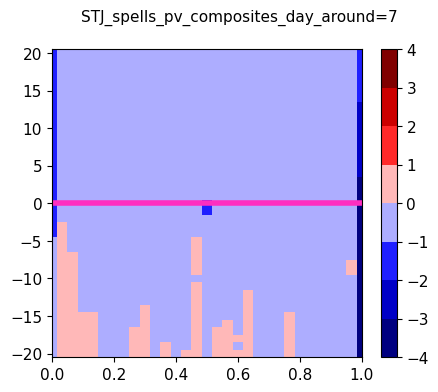

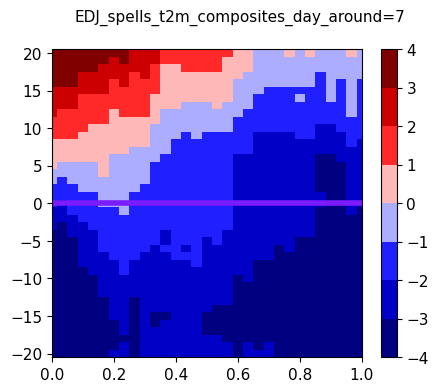

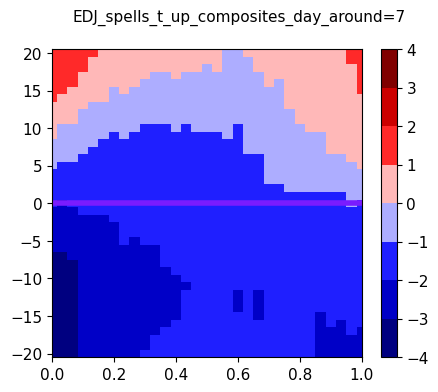

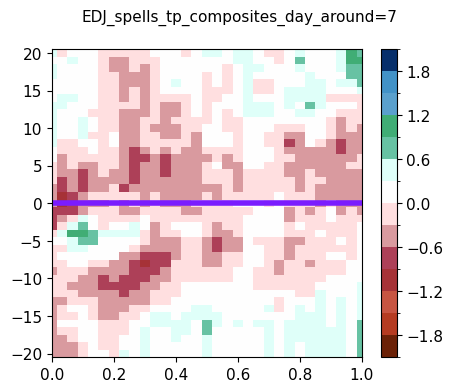

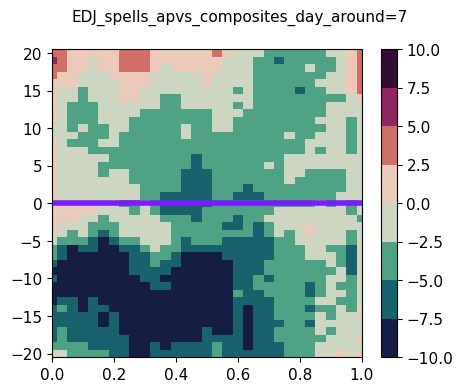

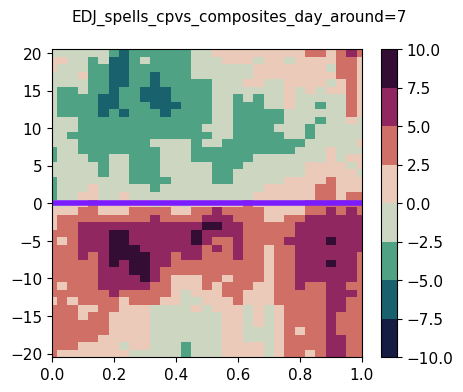

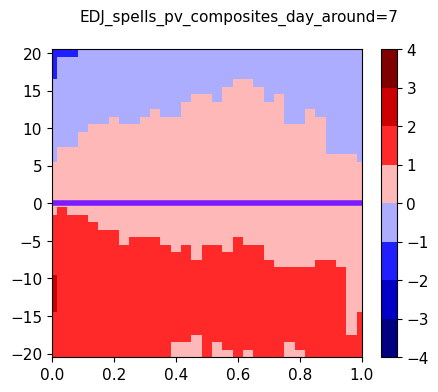

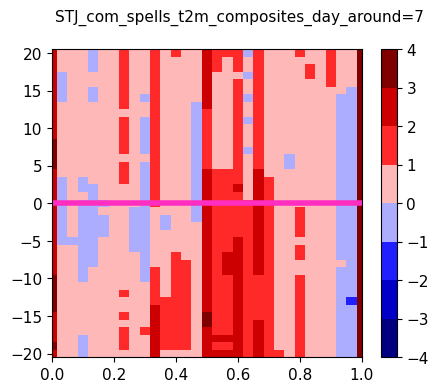

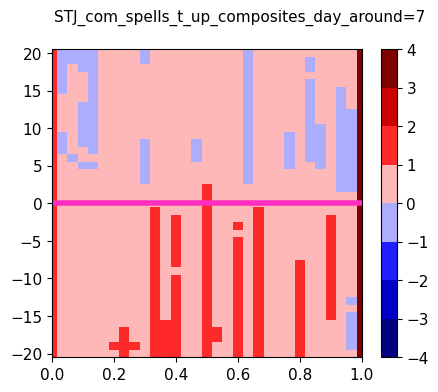

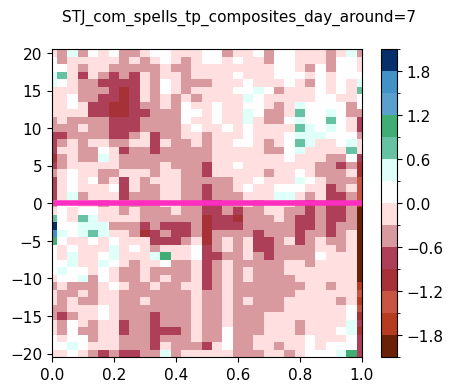

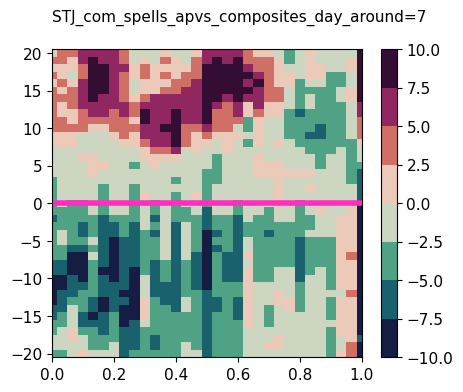

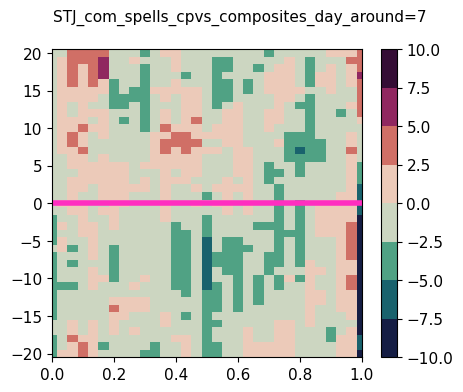

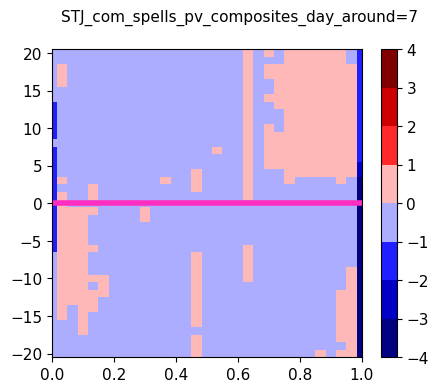

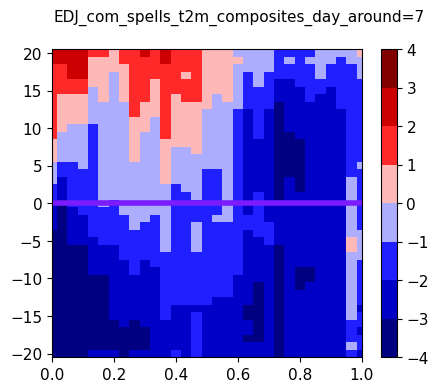

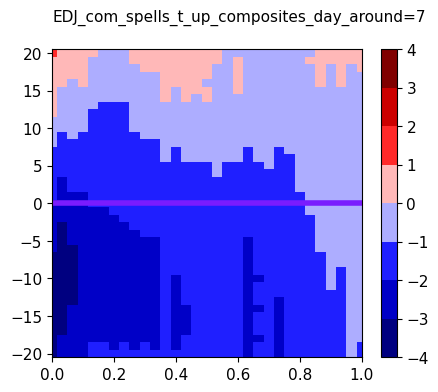

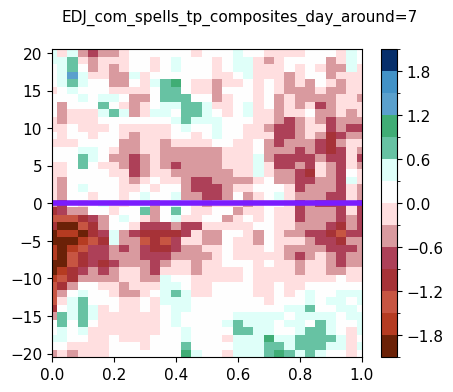

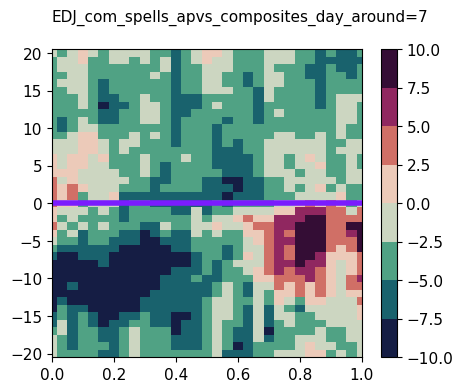

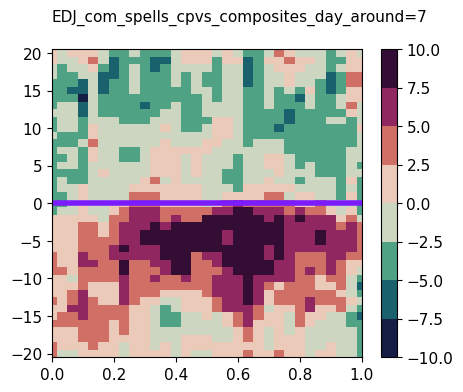

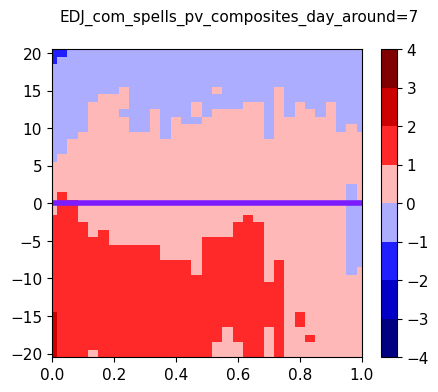

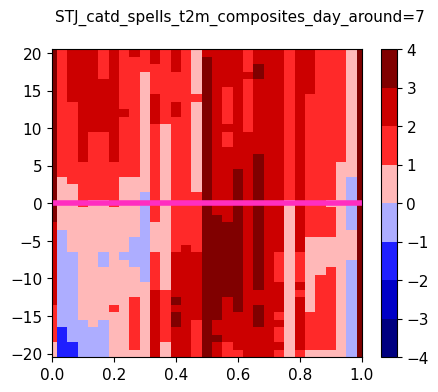

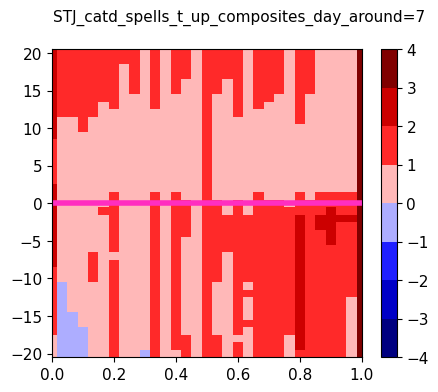

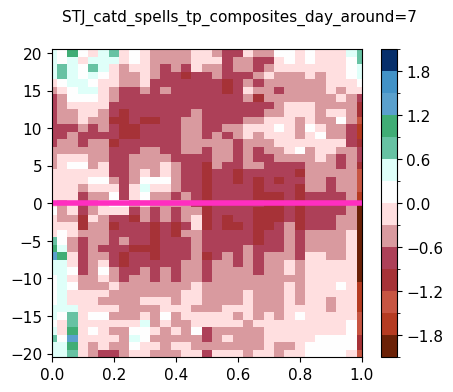

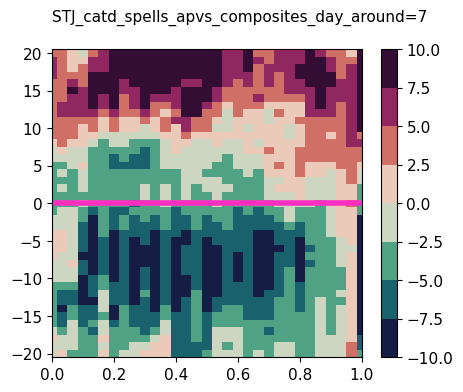

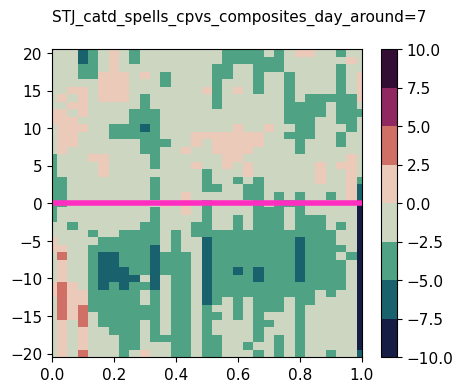

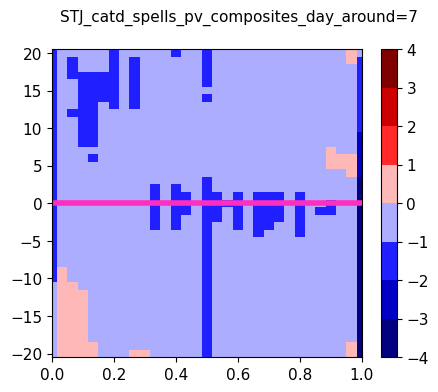

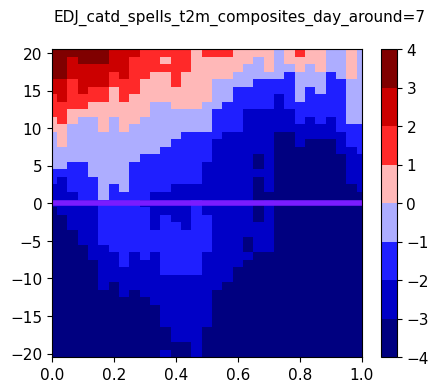

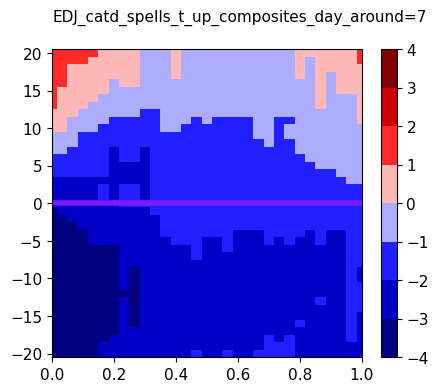

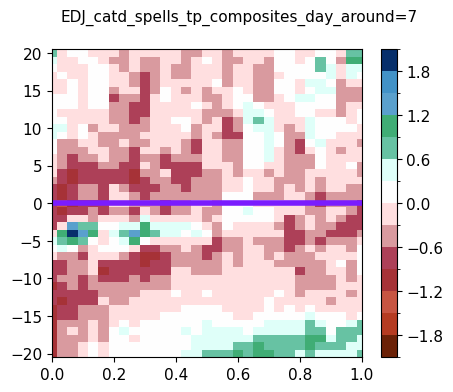

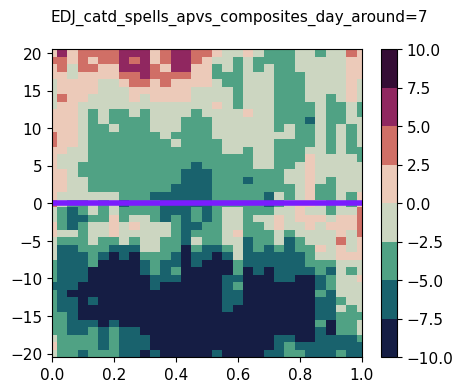

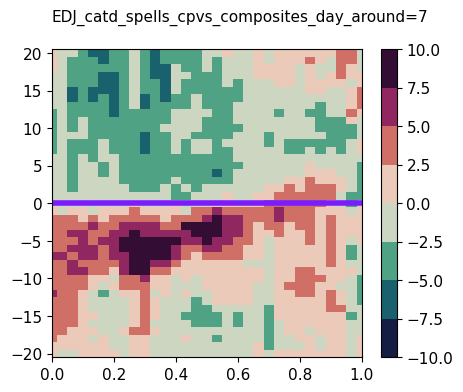

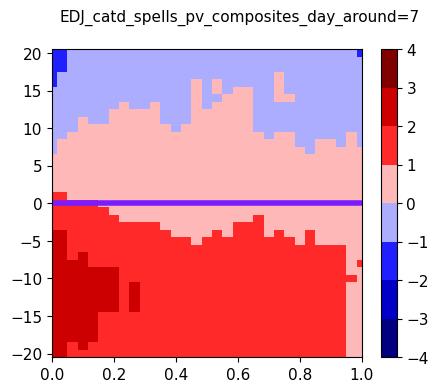

In [13]:
basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
# import os
# for file in basepath.glob("*.nc"):
#     os.remove(file)

clims = {
    "t2m": xr.open_dataarray(exp.path.joinpath("t2m_phat_relative_clim.nc")),
    "t_up": xr.open_dataarray(exp.path.joinpath("t300_phat_relative_clim.nc")),
    "tp": xr.open_dataarray(exp.path.joinpath("tp_phat_relative_clim.nc")) * 1000,
    "apvs" : xr.open_dataarray(exp.path.joinpath("apvs_phat_relative_clim.nc")) * 100,
    "cpvs": xr.open_dataarray(exp.path.joinpath("cpvs_phat_relative_clim.nc")) * 100,
    "pv": xr.open_dataarray(exp.path.joinpath("PV_phat_relative_clim.nc")) * 1e6,
}

variable_dict = {
    "t2m": [da_T, 8, colormaps.BlWhRe, [-4, 4]],
    "t_up": [da_T_upper, 8, colormaps.BlWhRe, [-4, 4]],
    "tp": [da_tp * 1000, 15, colormaps.precip4_diff_19lev, [-2, 2]],
    "apvs": [da_apvs * 100, 8, colormaps.curl, [-10, 10]],
    "cpvs": [da_cpvs * 100, 8, colormaps.curl, [-10, 10]],
    "pv": [da_pv * 1e6, 8, colormaps.BlWhRe, [-4, 4]],
}
# variable_dict = {
#     "t2m": [da_T, 8, colormaps.amp],
#     "t_up": [da_T_upper, 8, colormaps.amp],
#     "tp": [da_tp * 1000, 15, colormaps.deep],
#     "apvs": [da_apvs * 100, 8, colormaps.matter],
#     "cpvs": [da_cpvs * 100, 8, colormaps.matter],
#     "pv": [da_pv * 1e6, 8, colormaps.tempo],
# }
# for key in variable_dict:
#     clim = clims[key]
#     bounds = [clim.quantile(0.01), clim.quantile(1)]
#     variable_dict[key].append(bounds)
    
long_names = {
    "t2m": "2m temperature [K]",
    "t_up": "Upper level temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
    "pv": "Potential vorticity [PVU]",
}

n_bootstraps = '100'
days_around = [7]

for day_around in days_around:
    for spells_of in spells_list:
        spells_from_jet = daily_spells_list[spells_of]
        spells_from_jet = extend_spells(spells_from_jet)
        spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=day_around))
        jets = summer_daily.rename("time").to_frame().join(all_jets_one_df, on="time")
        times = spells_from_jet
        for i, (varname, props) in enumerate(tqdm(variable_dict.items())):
            da, nlevels, cmap, (min_, max_) = props
            clim = clims[varname]
            opath = basepath.joinpath(f"{da.name}_interp_spells_of_{spells_of}_{day_around=}.nc")
            opath_pvals = basepath.joinpath(f"{da.name}_interp_spells_of_{spells_of}_pvals_{day_around=}.nc")
            
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            if "jet ID" in times.columns:
                times = times.drop("jet ID")
            huh = gather_normal_da_jets_wrapper(
                jets, times, da, n_bootstraps=0, clim=clim
            )
            is_polar = spells_of[:3] == "EDJ"
            levels = MaxNLocator(nlevels).tick_values(min_, max_)
            norm = BoundaryNorm(levels, cmap.N)
            im = ax.pcolormesh(huh.norm_index, huh.n, huh.sel(is_polar=is_polar).values.T, shading="nearest", cmap=cmap, norm=norm)
            ax.plot([-.5, 1.5], [0, 0], lw=4, color=COLORS[2 - int(is_polar)])
            ax.set_xlim(0, 1)
            fig.colorbar(im, ax=ax)
            fig.suptitle(f"{spells_of}_spells_{varname}_composites_{day_around=}")

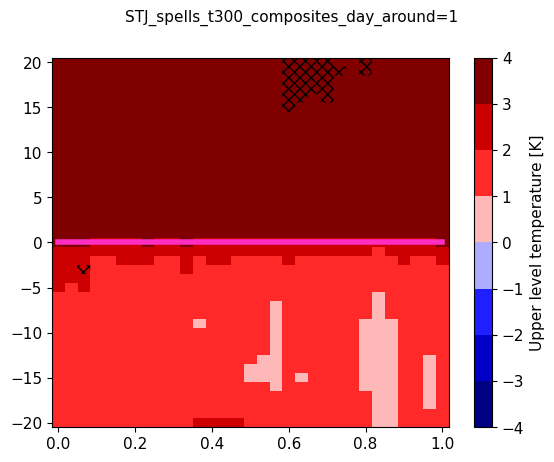

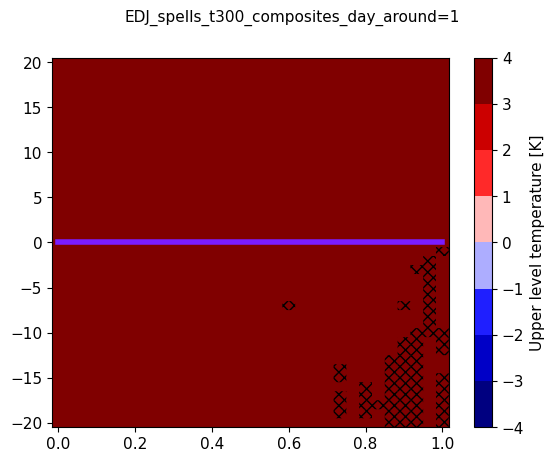

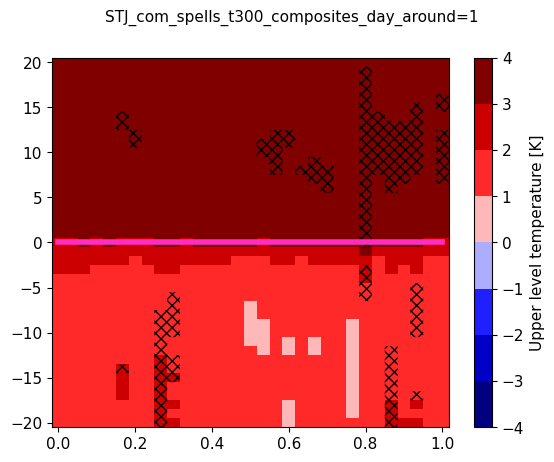

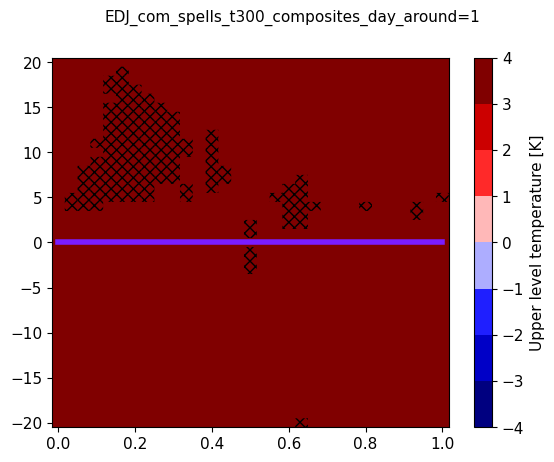

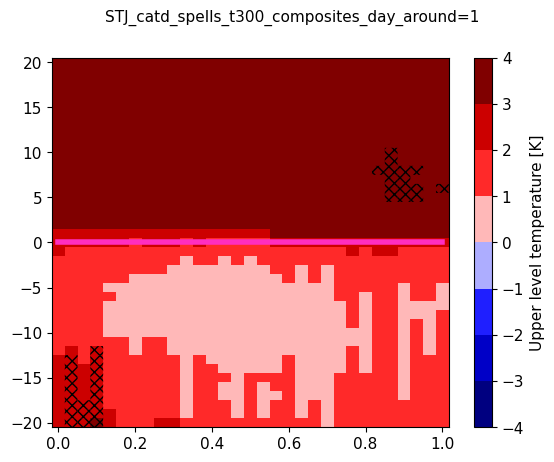

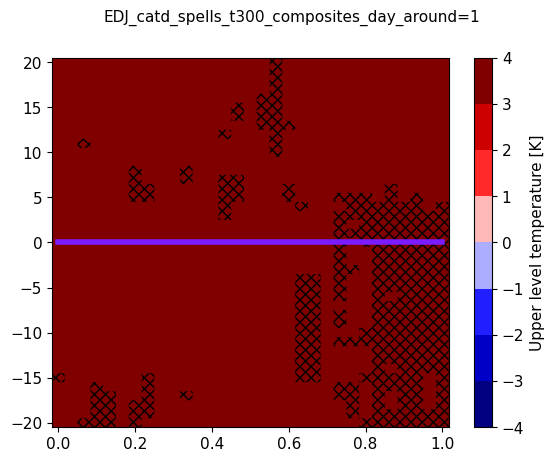

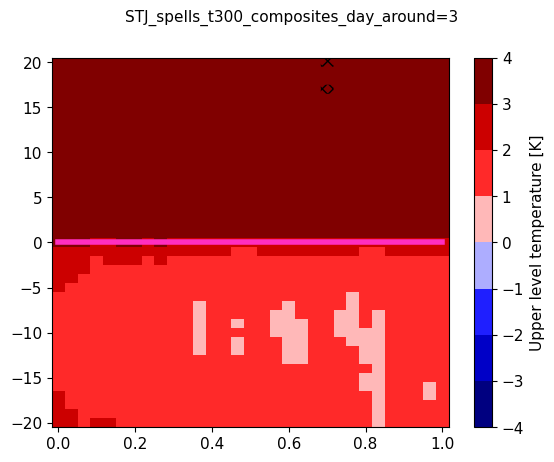

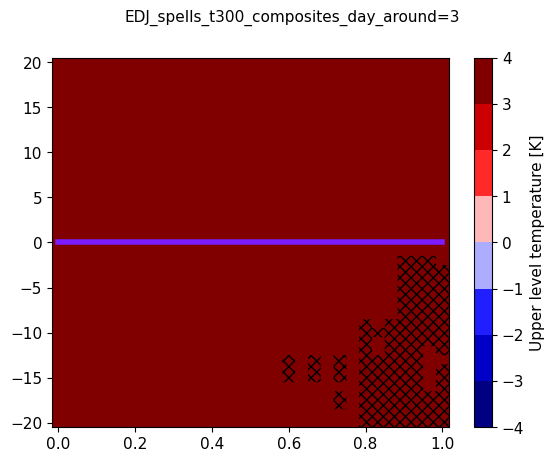

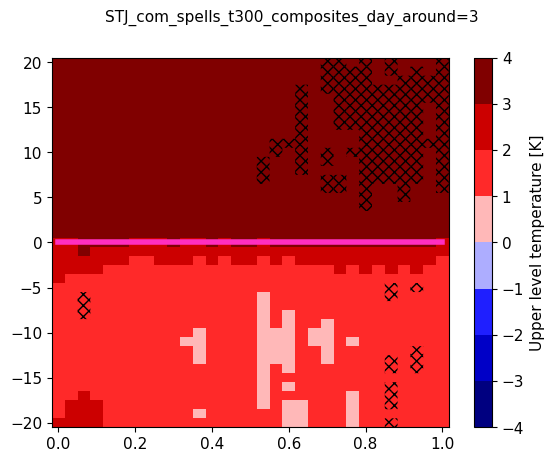

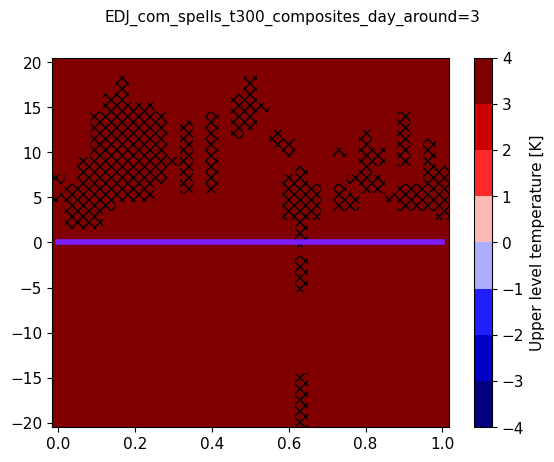

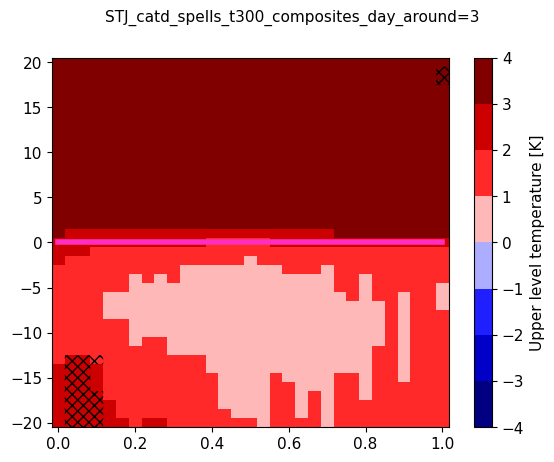

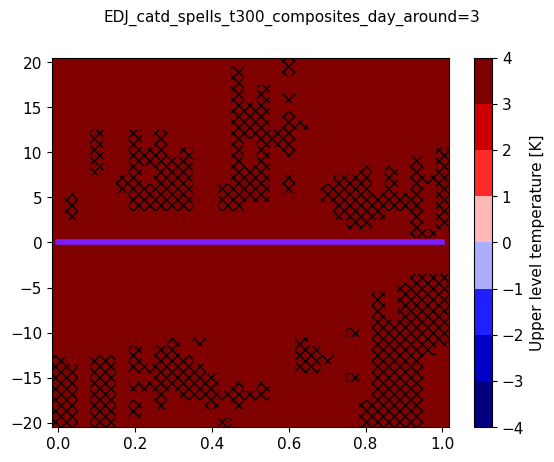

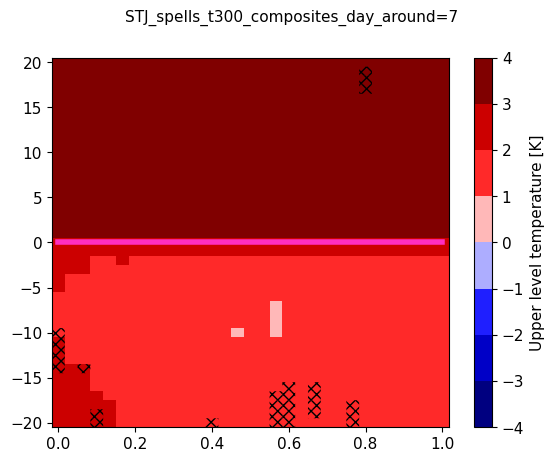

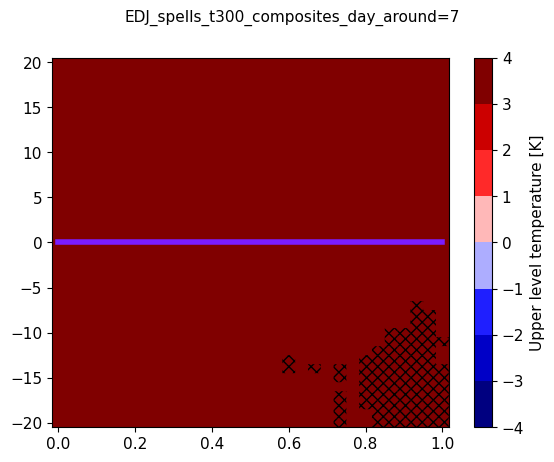

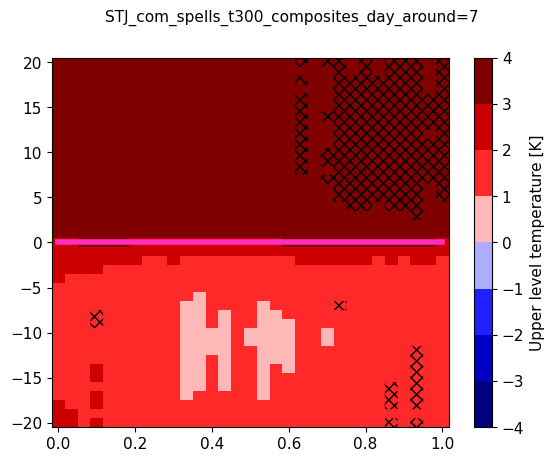

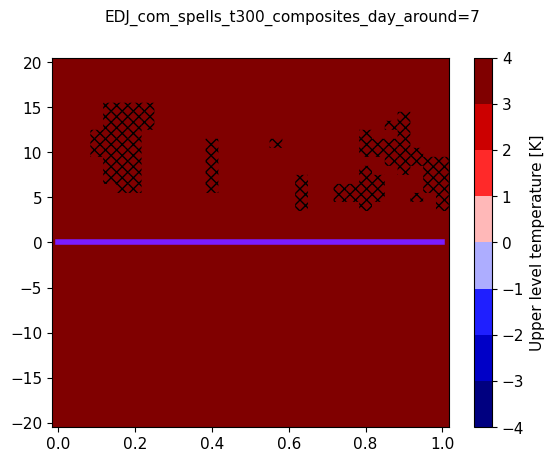

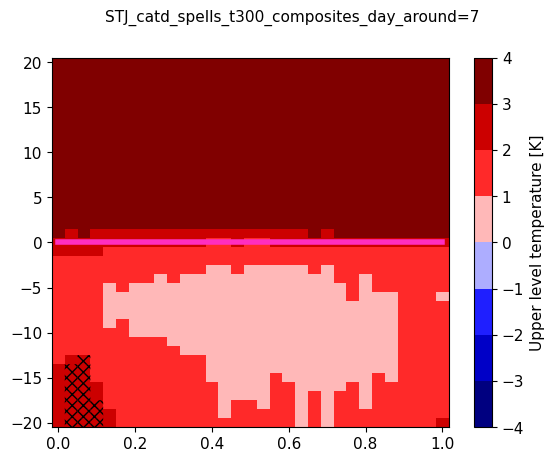

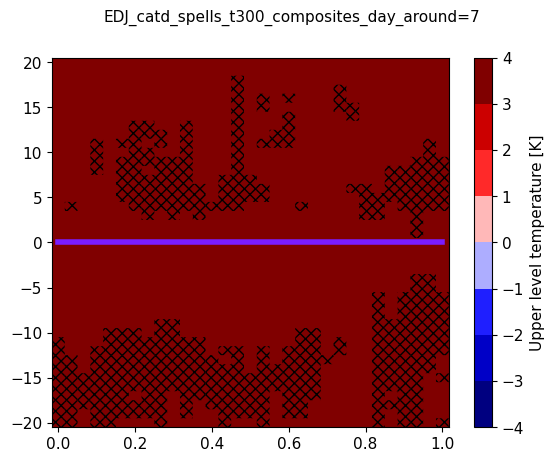

In [10]:
basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
day_around = 7
basepath_clim = exp.path
variable_dict = {
    "t2m": ["2m temperature [K]", 8, colormaps.BlWhRe, [-4, 4]],
    "t300": ["Upper level temperature [K]",8, colormaps.BlWhRe, [-4, 4]],
    "tp": ["Daily accum. precip. [mm]", 8, colormaps.precip4_diff_19lev, [-6, 6]],
    "apvs": [r"Anticyclonic RWB freq [$\%$]", 8, colormaps.curl, [-40, 40]],
    "cpvs": [r"Cyclonic RWB freq [$\%$]", 8, colormaps.curl, [-40, 40]],
    "PV": ["Potential vorticity [PVU]", 8, colormaps.BlWhRe, [-4, 4]]
}

hatch = "xxx"
for day_around in [1, 3, 7]:
    for varname in variable_dict:
        long_name, nlevels, cmap, [min_, max_] = variable_dict[varname]
        levels = MaxNLocator(nlevels).tick_values(min_, max_)
        norm = BoundaryNorm(levels, cmap.N)
        for spells_of in spells_list:
            tplt = xr.open_dataarray(basepath.joinpath(f"{da.name}_interp_spells_of_{spells_of}_{day_around=}.nc"), engine="netcdf4")
            pval = xr.open_dataarray(basepath.joinpath(f"{da.name}_interp_spells_of_{spells_of}_pvals_{day_around=}.nc"), engine="netcdf4")
            is_polar = spells_of[:3] == "EDJ"
            fig, ax = plt.subplots()
            im = ax.pcolormesh(tplt.norm_index, tplt.n, tplt.sel(is_polar=is_polar).values.T, shading="nearest", cmap=cmap, norm=norm)
            direction = infer_direction(tplt.sel(is_polar=is_polar))
            filter_ = symmetrize_p(pval.sel(is_polar=is_polar).T, direction, 0.05)
            ax.pcolor(pval.norm_index, pval.n, pval.sel(is_polar=is_polar).T.where(filter_), hatch="xxx", alpha=0.0)

            ax.plot([0, 1], [0, 0], lw=4, color=COLORS[2 - int(is_polar)])
            
            fig.colorbar(im, label=long_name)
            fig.suptitle(f"{spells_of}_spells_{varname}_composites_{day_around=}")
            fig.savefig(f"{FIGURES}/jet_persistence/{spells_of}_spells_{varname}_composites_{day_around=}.png")
            if varname != "t300":
                plt.close()

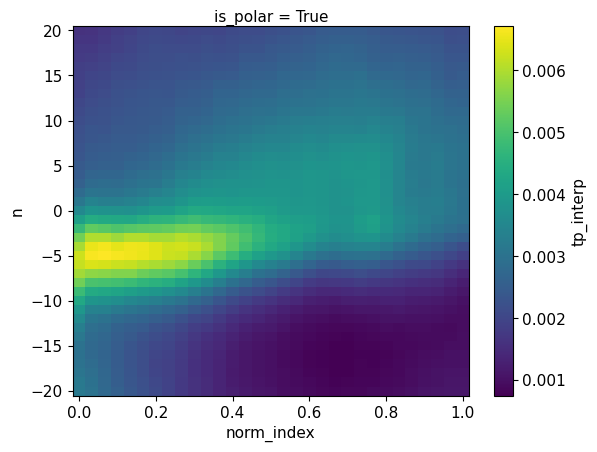

In [23]:
clims["tp"][160:340, 1].mean("dayofyear").plot()

In [11]:
tplt

<xarray.DataArray 'PV_interp' (is_polar: 2, norm_index: 31, n: 41)> Size: 20kB
[2542 values with dtype=float64]
Coordinates:
  * is_polar    (is_polar) bool 2B False True
  * norm_index  (norm_index) float64 248B 0.0 0.03333 0.06667 ... 0.9667 1.0
  * n           (n) float64 328B -20.0 -19.0 -18.0 -17.0 ... 17.0 18.0 19.0 20.0

# Real space composites

In [30]:
args = ["all", None, *get_region(ds), "all", "dayofyear", {"dayofyear": ("win", 15)}]
da_T_anom = open_da(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args
)
da_T_anom = compute(da_T_anom.sel(time=summer_daily), progress_flag=True)
da_tp_anom = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args
)
da_tp_anom = compute(da_tp_anom.sel(time=summer_daily), progress_flag=True)

[########################################] | 100% Completed | 28.52 s
[########################################] | 100% Completed | 30.85 s


In [31]:
plt.style.use("default")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

long_names = {
    "t2m": "2m temperature [K]",
    "t_up": "Upper level temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

In [35]:
da = da_T_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70))
levels = np.arange(-2.4, 2.4 + 0.8, 0.8)
levels = np.delete(levels, 3)
cmap = colormaps.BlWhRe
plot_kwargs = {"cmap": cmap, "levels": 7}

nrow, ncol = 4, 2
n = nrow * ncol
for jet in spells_list:
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        titles.append(f"{i} days, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=True, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    clu.fig.suptitle(jet)
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/{da.name}_realspace_{jet}.png")
    plt.close()

100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


In [34]:
da = da_tp_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70)) * 1000
cmap = colormaps.BlWhRe
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": 13,
    "q": 0.999,
    "transparify": 0,
}
nrow, ncol = 4, 2
n = nrow * ncol
for jet in spells_list:
    clu = Clusterplot(nrow, ncol, get_region(da))
    spells_from_jet_daily = daily_spells_list[jet]
    mask = np.zeros((len(da.time), n), dtype=bool)
    titles = []
    for i in range(n):
        this_rel_time = spells_from_jet_daily.filter(pl.col("relative_index")==i)
        mask[:, i] = np.isin(
            da.time.values,
            this_rel_time["time"]
        )
        n_spells = this_rel_time["spell"].n_unique()
        titles.append(f"{i} days, {n_spells} spells")
    _ = clu.add_any_contour_from_mask(da, mask, stippling=True, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    clu.fig.suptitle(jet)
    clu.resize_relative([1.1, 1])
    clu.fig.savefig(f"{FIGURES}/jet_persistence/{da.name}_realspace_{jet}.png")
    plt.close()

100%|██████████| 8/8 [00:00<00:00, 19.18it/s]
